In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device = 'cuda:0'

from torch.utils.data import DataLoader
from spac_gorillaloader import GorillaDataset, load_datapoints

batch_size = 32

datapoints = load_datapoints()

dataset_train = GorillaDataset(datapoints=datapoints, percent_start=0, percent_end=70)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = GorillaDataset(datapoints=datapoints, percent_start=70, percent_end=85)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = GorillaDataset(datapoints=datapoints, percent_start=85, percent_end=100)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


Using DP cache...
Deleted 15 datapoints due to data distribution.
GORILLA_DATA: Using data from index 0 to 604, covering 604, total 865 DP.
Deleted 41 datapoints due to data distribution.
GORILLA_DATA: Using data from index 605 to 734, covering 129, total 865 DP.
Deleted 29 datapoints due to data distribution.
GORILLA_DATA: Using data from index 735 to 864, covering 129, total 865 DP.


In [ ]:
import timm

#model = timm.create_model('resnet18.a1_in1k', in_chans=3, num_classes=len(label_mapping), pretrained=True)

# Create a ViT model for 3-channel input and 42 output classes
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    in_chans=3
)

In [ ]:
import torch
from gorilla_model import train


epochs = 100
learning_rate = 0.001


train(
    model,
    epochs=epochs,
    learning_rate=learning_rate,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
)

In [ ]:
torch.save(model.state_dict(), 'face_model.pth')

In [ ]:
import timm
from visualize import visualize_embeddings
import torch
from gorilla_reid.k_nearest_neighbor import calculate_accuracy, get_dataset_embeddings

device = 'cuda:0'

loaded_model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    in_chans=3
)

weights = torch.load('/workspace/gorilla_reid/checkpoints/epoch_73.pt', map_location=device)
loaded_model.load_state_dict(weights['model_state_dict'])
loaded_model = loaded_model.to(device)

# Load model weights into the model
loaded_model.eval()

batch_size = 32

# datapoints = load_datapoints()

# dataset_vis = GorillaDataset(datapoints=datapoints, percent_start=0, percent_end=100)
# dataloader_vis = DataLoader(dataset_vis, batch_size=batch_size, shuffle=True)

annotated_embeddings = get_dataset_embeddings(dataloader=dataloader_val, device=device, model=loaded_model)
accuracy = calculate_accuracy(annotated_search_space=annotated_embeddings)

Visualizing embeddings...:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 0.3068181818181818
Computing PCA...


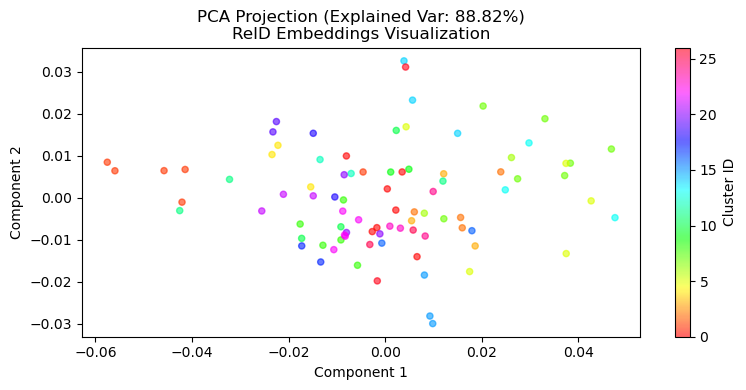


Visualization complete!
Original embedding dimension: 1000
Number of samples: 88
Number of unique clusters: 27
Computing t-SNE...


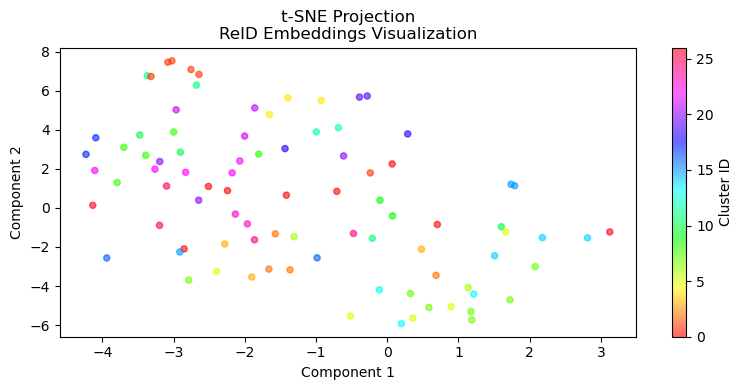


Visualization complete!
Original embedding dimension: 1000
Number of samples: 88
Number of unique clusters: 27


In [14]:
print(f'Accuracy: {accuracy}')

all_embeddings = [embedding.cpu() for label, embedding in annotated_embeddings]
all_labels = [label for label, embedding in annotated_embeddings]
visualize_embeddings(all_embeddings, all_labels, method='psa', figsize=(8, 4))
visualize_embeddings(all_embeddings, all_labels, method='tsne', figsize=(8, 4))